In [ ]:
from google.colab import drive #for uploading the file to collab
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!unzip "/content/drive/MyDrive/Pneumonia Project Folder/chest_xray.zip" -d chest_xray


Streaming output truncated to the last 5000 lines.
  inflating: chest_xray/chest_xray/__MACOSX/chest_xray/train/NORMAL/._IM-0439-0001.jpeg  
  inflating: chest_xray/chest_xray/__MACOSX/chest_xray/train/NORMAL/._IM-0440-0001.jpeg  
  inflating: chest_xray/chest_xray/__MACOSX/chest_xray/train/NORMAL/._IM-0441-0001.jpeg  
  inflating: chest_xray/chest_xray/__MACOSX/chest_xray/train/NORMAL/._IM-0442-0001.jpeg  
  inflating: chest_xray/chest_xray/__MACOSX/chest_xray/train/NORMAL/._IM-0444-0001.jpeg  
  inflating: chest_xray/chest_xray/__MACOSX/chest_xray/train/NORMAL/._IM-0445-0001.jpeg  
  inflating: chest_xray/chest_xray/__MACOSX/chest_xray/train/NORMAL/._IM-0446-0001.jpeg  
  inflating: chest_xray/chest_xray/__MACOSX/chest_xray/train/NORMAL/._IM-0447-0001.jpeg  
  inflating: chest_xray/chest_xray/__MACOSX/chest_xray/train/NORMAL/._IM-0448-0001.jpeg  
  inflating: chest_xray/chest_xray/__MACOSX/chest_xray/train/NORMAL/._IM-0449-0001.jpeg  
  inflating: chest_xray/chest_xray/__MACOSX/chest

In [ ]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader


transform = transforms.Compose([
    transforms.Grayscale(), #compression 3 rgb matrix into one for runtime
    transforms.Resize((224, 224)), # can downsample here for runtime
    transforms.ToTensor(),
])
#Loading train, test, and validation datasets.
train_dataset = datasets.ImageFolder("chest_xray/chest_xray/train", transform=transform)
test_dataset = datasets.ImageFolder("chest_xray/chest_xray/test", transform=transform)
val_dataset = datasets.ImageFolder("chest_xray/chest_xray/val", transform=transform)

#dataloaders w 32 images each for batches (randomized)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

print(train_dataset.classes) # classes for the data (train)



['NORMAL', 'PNEUMONIA']


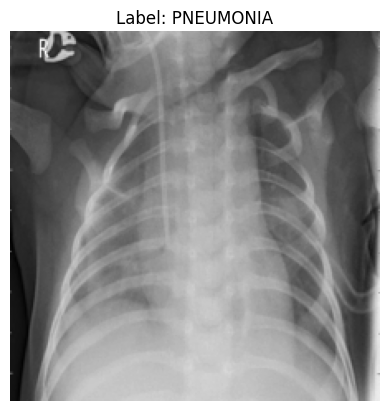

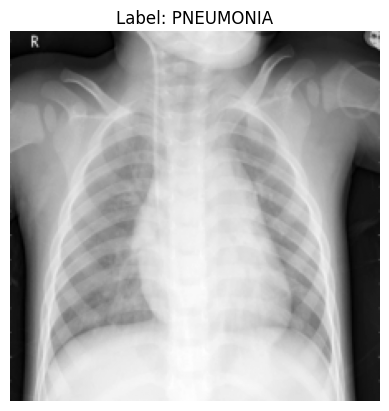

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

#image batch
dataiter = iter(train_loader)
images, labels = next(dataiter) #image, label pair


img_ten = images[0] #getting the 0th image/label pair
label = labels[0]

#tensor to NumPy (tensors no work for plotting :P)
img_np = img_ten.numpy()
img_np = np.transpose(img_np, (1, 2, 0))  #NOTE that the height/width need to be reordered when converting

#Image plot with the label on the top (thanks Chodrow!!!)
plt.imshow(img_np, cmap='gray')
plt.title(f"Label: {train_dataset.classes[label]}")
plt.axis("off")
plt.show()

i=10
pnu_img_ten = images[i]

pnu_label = labels[i]

pnu_img_np = pnu_img_ten.numpy()
pnu_img_np = np.transpose(pnu_img_np, (1, 2, 0))

plt.imshow(pnu_img_np, cmap='gray')
plt.title(f"Label: {train_dataset.classes[pnu_label]}")
plt.axis('off')
plt.show()


In [ ]:
#Image Dimension (for later)

pnu_img_ten.size()

torch.Size([1, 224, 224])

In [ ]:
## auto encoder
import torch
import torch.nn as nn
import torch.optim as optim
"""
B = batch size (32)

C = channels (1)

H = heightv (224)

W = width (224) """

# Autoencoder
class PneumoniaAutoencoder(nn.Module):
    def __init__(self):
        super(PneumoniaAutoencoder, self).__init__()
        # Encoder
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 16, 3, stride=2, padding=1),  # [B, 16, 112, 112]
            nn.ReLU(),
            nn.Conv2d(16, 32, 3, stride=2, padding=1), # [B, 32, 56, 56]
            nn.ReLU(),
            nn.Conv2d(32, 64, 3, stride=2, padding=1), # [B, 64, 28, 28]
            nn.ReLU(),
        )

        # Decoder
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(64, 32, 3, stride=2, padding=1, output_padding=1), # [B, 32, 56, 56]
            nn.ReLU(),
            nn.ConvTranspose2d(32, 16, 3, stride=2, padding=1, output_padding=1), # [B, 16, 112, 112]
            nn.ReLU(),
            nn.ConvTranspose2d(16, 1, 3, stride=2, padding=1, output_padding=1),  # [B, 1, 224, 224]
            nn.Sigmoid(),
        )

    def forward(self, x):
        latent = self.encoder(x)
        reconstructed = self.decoder(latent)
        return reconstructed


In [ ]:
## training

# Instantiate model, loss, optimizer
device = torch.device("cuda" if torch.cuda.is_available() else "cpu") #easy to switch between cpu and gpu
model = PneumoniaAutoencoder().to(device)

criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)



In [ ]:
from tqdm import tqdm

num_epochs = 1

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0

    # progress bar (really nice)
    pbar = tqdm(train_loader, desc=f"Epoch [{epoch+1}/{num_epochs}]")

    for images, _ in pbar:
        images = images.to(device)

        outputs = model(images)
        loss = criterion(outputs, images)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        # Update bar
        pbar.set_postfix({'loss': loss.item()})

    avg_loss = running_loss / len(train_loader)
    print(f"Epoch [{epoch+1}/{num_epochs}], Avg Loss: {avg_loss:.4f}")

Epoch [1/1]: 100%|██████████| 163/163 [01:08<00:00,  2.36it/s, loss=0.00271]

Epoch [1/1], Avg Loss: 0.0118


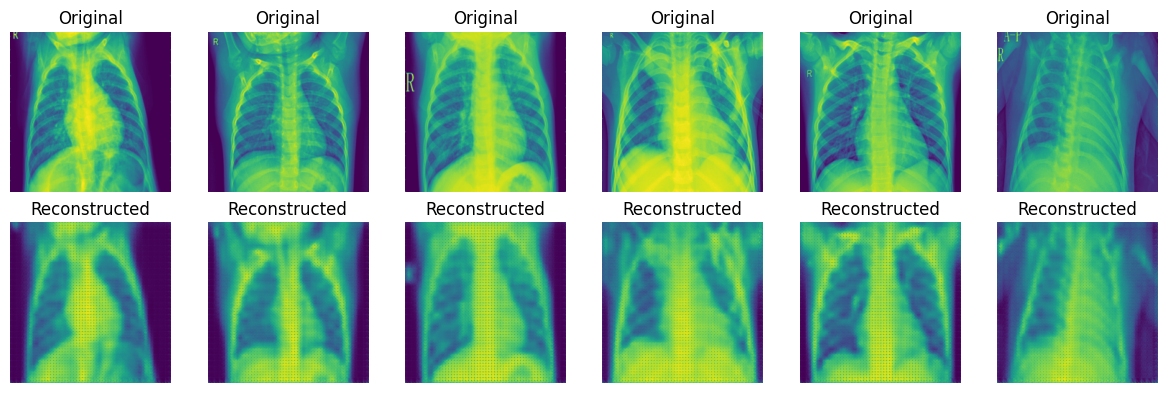

In [ ]:
## reconstructed images

import matplotlib.pyplot as plt
import numpy as np

# eval
model.eval()

# batch
dataiter = iter(train_loader)
images, _ = next(dataiter)
images = images.to(device)

# Reconstruct images
with torch.no_grad():
    reconstructions = model(images)

# Move tensors to CPU for plotting (np can't use gpu)
images = images.cpu()
reconstructions = reconstructions.cpu()

#transpose for tensor --> numpy
def tensor_to_img(t):
    t = t.numpy()
    t = np.transpose(t, (1, 2, 0))
    return t

# Plot original and reconstructed
n = 6 #num images
plt.figure(figsize=(12, 4))
for i in range(n):
    # Original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(tensor_to_img(images[i]))
    ax.set_title("Original")
    plt.axis("off")

    # Reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(tensor_to_img(reconstructions[i]))
    ax.set_title("Reconstructed")
    plt.axis("off")

plt.tight_layout()
plt.show()


## PCA plot to understand if differences encoded are meaningful

In [ ]:
model.eval()
latent_vectors = []
labels_list = []

with torch.no_grad():
    for images, labels in train_loader:  # labels: 0=norm, 1=pneu
        images = images.to(device)
        encoded = model.encoder(images)
        # Flatten
        encoded = encoded.view(encoded.size(0), -1).cpu().numpy()
        latent_vectors.append(encoded)
        labels_list.append(labels.cpu().numpy())

# Stack into arrays
import numpy as np
X = np.vstack(latent_vectors)
y = np.hstack(labels_list)

from sklearn.decomposition import PCA

pca = PCA(n_components=2) #2 Principal components
X_pca = pca.fit_transform(X)


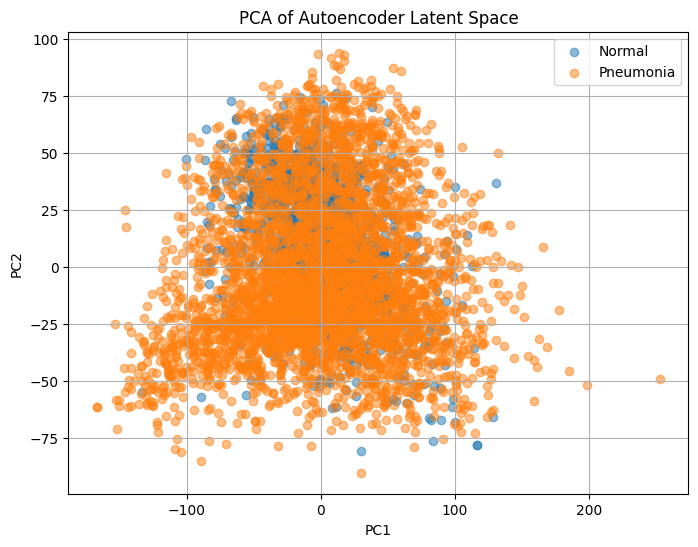

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
plt.scatter(X_pca[y==0, 0], X_pca[y==0, 1], label="Normal", alpha=0.5)
plt.scatter(X_pca[y==1, 0], X_pca[y==1, 1], label="Pneumonia", alpha=0.5)
plt.title("PCA of Autoencoder Latent Space")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.legend()
plt.grid(True)
plt.show()


## Contrastive Loss

In [ ]:
class ContrastiveEncoder(nn.Module):
    def __init__(self, latent_dim=64):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 32, 4, 2, 1),  #didn't spend too much time here since it didn't do great.
            nn.ReLU(),
            nn.Conv2d(32, 64, 4, 2, 1),
            nn.ReLU(),
            nn.Flatten()
        )
        self.flattened_size = 64 * 56 * 56
        self.fc_mu = nn.Linear(self.flattened_size, latent_dim)

    def forward(self, x):
        x = self.encoder(x)
        mu = self.fc_mu(x)
        return mu


In [ ]:
def train_encoder(model, dataloader, optimizer, device, epochs=10):
    model.train()
    for epoch in range(epochs):
        total_loss = 0
        for x, y in tqdm(dataloader, desc=f"Epoch {epoch+1}/{epochs}"):
            x, y = x.to(device), y.to(device)
            optimizer.zero_grad()
            mu = model(x)
            loss = supervised_contrastive_loss(mu, y)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        print(f"Epoch {epoch+1} - Contrastive Loss: {total_loss / len(dataloader):.4f}")


In [ ]:
import plotly.express as px

def plot_latent_space_3d(model, dataloader, device):
    model.eval()
    mus = []
    labels = []

    with torch.no_grad():
        for x, y in dataloader:
            x = x.to(device)
            mu = model(x)
            mus.append(mu.cpu().numpy())
            labels.append(y.numpy())

    mus = np.concatenate(mus, axis=0)
    labels = np.concatenate(labels, axis=0)

    # PCA
    pca = PCA(n_components=3)
    reduced = pca.fit_transform(mus)

    # pd.data.frame for plotly!
    import pandas as pd
    df = pd.DataFrame({
        'PC1': reduced[:, 0],
        'PC2': reduced[:, 1],
        'PC3': reduced[:, 2],
        'Label': labels
    })

    fig = px.scatter_3d(df, x='PC1', y='PC2', z='PC3',
                        color=df['Label'].astype(str),
                        title='3D PCA of Latent Space',
                        labels={'color': 'Class'},
                        opacity=0.7)
    fig.update_traces(marker=dict(size=4))
    fig.show()


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = ContrastiveEncoder(latent_dim=64).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

train_encoder(
    model,
    train_loader,
    optimizer,
    device,
    epochs=10)


Epoch 1/10: 100%|██████████| 163/163 [01:11<00:00,  2.27it/s]


Epoch 1 - Contrastive Loss: 10229413499.0815


Epoch 2/10: 100%|██████████| 163/163 [01:10<00:00,  2.31it/s]


Epoch 2 - Contrastive Loss: 5984462881873.6689


Epoch 3/10: 100%|██████████| 163/163 [01:10<00:00,  2.31it/s]


Epoch 3 - Contrastive Loss: 165640260111605.0000


Epoch 4/10: 100%|██████████| 163/163 [01:11<00:00,  2.28it/s]


Epoch 4 - Contrastive Loss: 1046564519824227.0000


Epoch 5/10: 100%|██████████| 163/163 [01:10<00:00,  2.30it/s]


Epoch 5 - Contrastive Loss: 4228928954451226.5000


Epoch 6/10: 100%|██████████| 163/163 [01:09<00:00,  2.33it/s]


Epoch 6 - Contrastive Loss: 9165964179117364.0000


Epoch 7/10: 100%|██████████| 163/163 [01:07<00:00,  2.40it/s]


Epoch 7 - Contrastive Loss: 41170843080356120.0000


Epoch 8/10: 100%|██████████| 163/163 [01:10<00:00,  2.33it/s]


Epoch 8 - Contrastive Loss: 62285426339613840.0000


Epoch 9/10: 100%|██████████| 163/163 [01:08<00:00,  2.38it/s]


Epoch 9 - Contrastive Loss: 210256527717879648.0000


Epoch 10/10: 100%|██████████| 163/163 [01:09<00:00,  2.33it/s]

Epoch 10 - Contrastive Loss: 280468405382119232.0000


In [ ]:
plot_latent_space_3d(model, train_loader, device)

## Variational AutoEncoder with Contrastive loss

In [ ]:
from tqdm import tqdm
import torch
import torch.nn as nn
import numpy as np
from sklearn.decomposition import PCA
#variational autoencoder w contrastive learning :)
class ContrastiveVAE(nn.Module):
    def __init__(self, latent_dim=64):
        super(ContrastiveVAE, self).__init__()
        self.latent_dim = latent_dim

        # Encoder CNN
        self.encoder_cnn = nn.Sequential(
            nn.Conv2d(1, 32, 4, 2, 1),  # (B, 32, 112, 112)
            nn.ReLU(),
            nn.Conv2d(32, 64, 4, 2, 1), # (B, 64, 56, 56)
            nn.ReLU(),
        )

        self.flattened_size = 64 * 56 * 56
        self.encoder_flatten = nn.Flatten()
        self.fc_mu = nn.Linear(self.flattened_size, latent_dim)
        self.fc_logvar = nn.Linear(self.flattened_size, latent_dim)

        # Decoder (not really using had from before)
        self.decoder_input = nn.Linear(latent_dim, self.flattened_size)
        self.decoder = nn.Sequential(
            nn.Unflatten(1, (64, 56, 56)),
            nn.ConvTranspose2d(64, 32, 4, 2, 1),  # (B, 32, 112, 112)
            nn.ReLU(),
            nn.ConvTranspose2d(32, 1, 4, 2, 1),   # (B, 1, 224, 224)
            nn.Sigmoid()
        )

    def encode(self, x):
        x = self.encoder_cnn(x)
        x = self.encoder_flatten(x)
        mu = self.fc_mu(x)
        logvar = self.fc_logvar(x)
        return mu, logvar

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z):
        x = self.decoder_input(z)
        x = self.decoder(x)
        return x

    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        x_recon = self.decode(z)
        return x_recon, mu, logvar



In [ ]:
def supervised_contrastive_loss(embeddings, labels, temperature=0.1):
  #contrastive loss function for VAE

    device = embeddings.device
    labels = labels.contiguous().view(-1, 1)
    mask = torch.eq(labels, labels.T).float().to(device)

    dot_product = (embeddings @ embeddings.T) / temperature
    logits_max, _ = torch.max(dot_product, dim=1, keepdim=True)
    logits = dot_product - logits_max.detach()

    exp_logits = torch.exp(logits) * (1 - torch.eye(len(labels), device=device))
    log_prob = logits - torch.log(exp_logits.sum(1, keepdim=True) + 1e-8)

    mean_log_prob_pos = (mask * log_prob).sum(1) / mask.sum(1)
    loss = -mean_log_prob_pos.mean()
    return loss


In [ ]:
def train_vae(model, dataloader, optimizer, device, epochs=10, beta=1.0, contrastive_weight=1.0):
    model.train()
    recon_loss_fn = nn.MSELoss(reduction='sum')

    for epoch in range(epochs):
        total_loss = 0
        for x, y in tqdm(dataloader, desc=f"Epoch {epoch+1}/{epochs}"):
            x, y = x.to(device), y.to(device)
            optimizer.zero_grad()

            x_recon, mu, logvar = model(x)
            recon_loss = recon_loss_fn(x_recon, x) / x.size(0)

            kl_loss = -0.5 * torch.mean(1 + logvar - mu.pow(2) - logvar.exp())

            contrastive = supervised_contrastive_loss(mu, y)

            loss = recon_loss + beta * kl_loss + contrastive_weight * contrastive
            loss.backward()
            optimizer.step()

            total_loss += loss.item()

        print(f"Epoch {epoch+1} - Loss: {total_loss / len(dataloader):.4f}")


In [ ]:
import plotly.express as px

def plot_latent_space_3d(model, dataloader, device):
    model.eval()
    mus = []
    labels = []

    with torch.no_grad():
        for x, y in dataloader:
            x = x.to(device)
            mu, _ = model.encode(x)
            mus.append(mu.cpu().numpy())
            labels.append(y.numpy())

    mus = np.concatenate(mus, axis=0)
    labels = np.concatenate(labels, axis=0)

    # PCA for visualization
    pca = PCA(n_components=3)
    reduced = pca.fit_transform(mus)

    # Create pd.data.frame for Plotly
    import pandas as pd
    df = pd.DataFrame({
        'PC1': reduced[:, 0],
        'PC2': reduced[:, 1],
        'PC3': reduced[:, 2],
        'Label': labels
    })

    fig = px.scatter_3d(df, x='PC1', y='PC2', z='PC3',
                        color=df['Label'].astype(str),
                        title='3D PCA of Latent Space',
                        labels={'color': 'Class'},
                        opacity=0.7)
    fig.update_traces(marker=dict(size=4))
    fig.show()


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = ContrastiveVAE(latent_dim=64).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

train_vae(
    model,
    train_loader,
    optimizer,
    device,
    epochs=10,
    beta=1.0,
    contrastive_weight=5 # 5 ~208, 10 ~ 229
)


Epoch 1/10: 100%|██████████| 163/163 [09:00<00:00,  3.31s/it]


Epoch 1 - Loss: 1687.3250


Epoch 2/10: 100%|██████████| 163/163 [09:04<00:00,  3.34s/it]


Epoch 2 - Loss: 519.7350


Epoch 3/10: 100%|██████████| 163/163 [09:04<00:00,  3.34s/it]


Epoch 3 - Loss: 374.9746


Epoch 4/10: 100%|██████████| 163/163 [09:08<00:00,  3.37s/it]


Epoch 4 - Loss: 318.8155


Epoch 5/10: 100%|██████████| 163/163 [09:44<00:00,  3.59s/it]


Epoch 5 - Loss: 279.6557


Epoch 6/10: 100%|██████████| 163/163 [10:11<00:00,  3.75s/it]


Epoch 6 - Loss: 261.5756


Epoch 7/10:  37%|███▋      | 60/163 [03:43<06:17,  3.66s/it]

In [ ]:
plot_latent_space_3d(model, train_loader, device)


## Testing on Model to see how well it performs

In [25]:
def extract_latent_vectors(model, dataloader, device):
    model.eval()
    all_mu = []
    all_labels = []

    with torch.no_grad():
        for x, y in dataloader:
            x = x.to(device)
            mu, _ = model.encode(x)
            all_mu.append(mu.cpu().numpy()) #add all into np array
            all_labels.append(y.numpy())

    X = np.concatenate(all_mu, axis=0)
    y = np.concatenate(all_labels, axis=0)
    return X, y


In [26]:
X_train, y_train = extract_latent_vectors(model, train_loader, device)
X_test, y_test = extract_latent_vectors(model, test_loader, device)


In [32]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score

model_test = LogisticRegression(max_iter=100, verbose = 1)
model_test.fit(X_train, y_train)

y_pred = model_test.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred, digits=4))


Accuracy: 0.7435897435897436
              precision    recall  f1-score   support

           0     0.9512    0.3333    0.4937       234
           1     0.7122    0.9897    0.8283       390

    accuracy                         0.7436       624
   macro avg     0.8317    0.6615    0.6610       624
weighted avg     0.8018    0.7436    0.7028       624



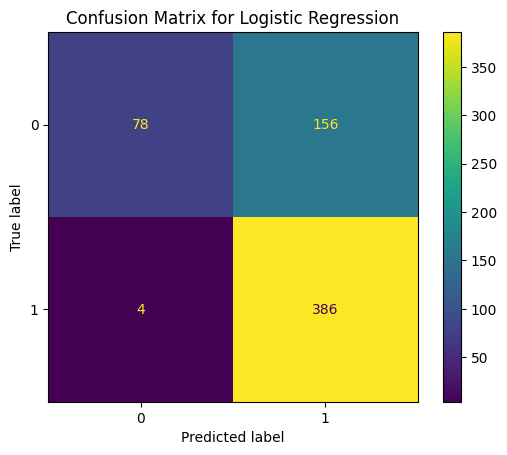

In [34]:
from sklearn.metrics import ConfusionMatrixDisplay

ConfusionMatrixDisplay.from_estimator(model_test, X_test, y_test)
plt.title("Confusion Matrix for Logistic Regression")
plt.show()
